In [47]:
import pandas as pd
import numpy as np
import sklearn
import nltk
import re
import os
import random
import codecs
import mpld3
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import pylab
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Load data and pick a sample of 10%
data = pd.read_pickle("darklyrics/artist_data_normal.pkl")
#data = data.sample(frac=0.1)

In [48]:
# http://www.metalstorm.net/users/list.php?list_id=2413
top_bands = [
    "black sabbath", "judas priest", "slipknot", "iron maiden", "metallica", "venom", "motorhead",
    "slayer", "celtic frost", "bathory", "helloween", "possessed", "death", "pantera", "godflesh", "morbid angel",
    "paradise lost", "at the gates", "mercyful fate", "accept", "melvins", "budgie", "queensryche", "kreator",
    "napalm death", "gorguts", "sepultura", "dream theater", "mayhem", "yngwie malmsteen", "manowar", "candlemass",
    "watchtower", "burzum", "emperor", "atheist", "repulsion", "pentagram", "trouble", "saint vitus", "entombed",
    "obituary", "neurosis", "ministry", "suffocation", "diamond head", "anthrax", "darkthrone", "megadeth",
    "autopsy", "savatage", "fates warning", "suicidal tendencies", "carcass", "deicide", "exodus", "amorphis",
    "fear factory", "immortal", "sodom", "my dying bride", "the gathering", "theatre of tragedy", "dark angel",
    "the 3rd and the mortal", "saxon", "thergothon", "earth", "opeth", "isis", "sleep", "blind guardian", "therion",
    "in flames", "d.r.i.", "meshuggah", "rhapsody of fire", "stratovarius", "manilla road", "destruction", u"sarcófago",
    "tiamat", "nightwish", "children of bodom", "enslaved", "dissection", "dark tranquillity", "master's hammer", 
    "master", "cannibal corpse", "nocturnus", "crimson glory", "anathema", "bethlehem", "cathedral", "ulver",
    "katatonia", "terrorizer", "w.a.s.p.", "raven", "anvil", "dio", "gamma ray", "ozzy osbourne", "skyclad", "cynic",
    "type o negative", "skepticism", "disembowelment", "danzig", "graveland", "rotting christ", "sentenced", 
    "immolation", "bolt thrower", "exhumed", "angel witch", "winter", "vulcano", "corrosion of conformity", 
    "king diamond", "machine head", "eyehategod", "crowbar", "carnivore", "exhorder", "unholy", "prong", 
    "testament", "overkill", "slaughter", "massacre", "voivod", "hammerfall", "dimmu borgir", "cradle of filth", 
    "finntroll", "satyricon", "in the woods...", "mastodon", "witchfinder general", "running wild", "metal church", 
    "marduk", "samael", "strapping young lad",  "symphony x", "nile", "summoning", "dillinger escape plan", 
    "converge"
]
data = data.to_frame()
data = data.reset_index()

In [3]:
not_found = []
for band in top_bands:
    filtered = data[data['artist'] == band]
    if len(filtered) == 0:
        not_found.append(band)
print not_found
data = data[data['artist'].isin(top_bands)]
data

[]


,artist,lyrics_string
153,accept,crash bars door stomping town crowd crush beyo...
378,amorphis,retired towering mountain laid circle stones t...
407,anathema,tonight im free free first time ive seen new l...
438,angel witch,time stops pass mind know im kind see things n...
485,anthrax,die screaming give want gonna get get either w...
501,anvil,yo ho ho yo ho ho give us bottle rum yo ho ho ...
683,at the gates,trail serpent models fear generation buried be...
693,atheist,second sun second sun like jupiter ones atoms ...
732,autopsy,saw woods sneaking like rat sick pleasure mind...
824,bathory,night divides day dark come everyone fear stri...


## TF-IDF Vectorization

In [49]:
begin = time()
vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words='english', min_df=10, max_df=0.5)
x = vectorizer.fit_transform(data['lyrics_string'])
end = time()
print 'TFIDF vectorization performed in %f seconds' % (end - begin)
print 'Num samples: %d, num features: %d' % x.shape
features = vectorizer.get_feature_names()

TFIDF vectorization performed in 17.214819 seconds
Num samples: 7433, num features: 27514


## Clustering

In [50]:
from sklearn.metrics.pairwise import cosine_similarity
distance = 1 - cosine_similarity(x)

In [51]:
num_clusters = 15
km = KMeans(n_clusters=num_clusters)
begin = time()
km.fit(x)
end = time()
print 'K means computed in %f' % (end - begin)

K means computed in 128.299275


In [60]:
from sklearn.externals import joblib

joblib.dump(km, 'darklyrics/doc_cluster.pkl')
#km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [53]:
data['cluster'] = clusters
data['cluster'].value_counts()

1     1469
2     1321
3      873
4      822
6      632
13     466
12     419
7      381
0      368
9      262
8      224
14     114
10      34
11      26
5       22
Name: cluster, dtype: int64

In [54]:
print "Top terms per cluster:"
print ""

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print "Cluster %d words: " % i
    print ""
    
    for ind in order_centroids[i, :20]: #replace 6 with n words per cluster
        print ' %s' % features[ind].encode('utf-8', 'ignore'),
    print ""
    print ""
    
    print "Cluster %d artists:" % i
    for artist_index, row in data[data['cluster'] == i].iterrows():
        print ('%s,' % row['artist']),
    print ""
    print ""

Top terms per cluster:

Cluster 0 words: 

 sword  battle  shall  gods  king  men  steel  ride  warriors  wind  glory  swords  ancient  mighty  evil  lands  great  lord  high  victory 

Cluster 0 artists:
abbath, absurd, abused majesty, achsar, adiastasia, adorned brood, adramelech, aeternus, aina, airged l'amh, alkonost, amon amarth, amorgen, anarchy, ancient bards, ancient spheres, andras, angeli di pietra, apraxia, arafel, arghoslent, arkham witch, ases, aska, athos, atlantean kodex, attick demons, azeroth, balfor, bane of winterstorm, bathory, battleheart, battlelore, battlelust, battlemaster, battleroar, battlesoul, berserk, berserkr, bilskirnir, black messiah, black orchid, bloodthorn, bodyfarm, bornholm, bran barr, bretwaldas of heathen doom, burning in hell, cadacross, caladan brood, carnal agony, castle, cauldron born, celesty, celtachor, celtibeerian, centimani, centurion, christopher lee, chronomancy, chthonic, circle of grief, cirith gorgor, civil war, claymore, claymorean,

In [55]:
from sklearn.manifold import MDS

MDS()
mds = MDS(dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(distance)
xs, ys = pos[:, 0], pos[:, 1]

In [56]:
cluster_tags = {}
cluster_colors = {}
r_color = lambda: random.randint(0,255)

order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):    
    tags = ""
    for ind in order_centroids[i, :7]: #replace 6 with n words per cluster
        tags = tags + features[ind].encode('utf-8', 'ignore') + " "
    cluster_tags[i] = tags
    cluster_colors[i] = '#%02X%02X%02X' % (r_color(),r_color(),r_color())
    
cluster_tags

{0: 'sword battle shall gods king men steel ',
 1: 'shall fucking evil people eternal gods fuck ',
 2: 'youve change forget thats save wrong control ',
 3: 'wind shall stars moon shadows eternal rain ',
 4: 'shall evil existence self fucking control final ',
 5: 'la hey yeah el gonna ya fuck ',
 6: 'fly evil rain wind tonight save change ',
 7: 'yeah gonna wanna baby aint gotta hey ',
 8: 'satan evil shall christ lord holy unholy ',
 9: 'thy shall thou thee lord ancient eternal ',
 10: 'nie si ci jak na mnie jest ',
 11: 'ja ei kun silm el si saa ',
 12: 'fucking fuck shit youve fucked bitch better ',
 13: 'youve change said fucking better wrong forget ',
 14: 'metal steel evil heavy tonight ride battle '}

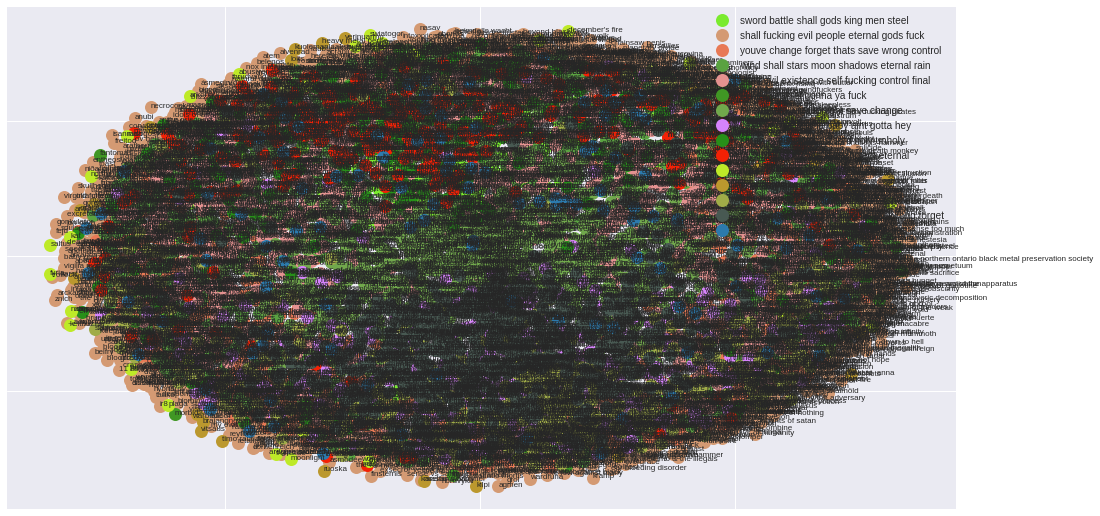

In [57]:
%matplotlib inline 

data['x'] = xs
data['y'] = ys
clustered = data.groupby('cluster')

fig, ax = plt.subplots(figsize=(17, 9))
ax.margins(0.05)

for name, group in clustered:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=13, 
            label=cluster_tags[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',
        which='both',
        bottom='off', 
        top='off',  
        labelbottom='off')
    ax.tick_params(\
        axis= 'y', 
        which='both',
        left='off',
        top='off',
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i, row in data.iterrows():
    ax.text(row['x'], row['y'], row['artist'], size=8)  
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [58]:
class TweakToolbar(mpld3.plugins.PluginBase):
    """Plugin for changing toolbar"""

    JAVASCRIPT = """
    mpld3.register_plugin("tweaktoolbar", TweakToolbar);
    TweakToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TweakToolbar.prototype.constructor = TweakToolbar;
    function TweakToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TweakToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the toolbar as desired

      // show toolbar
      this.fig.toolbar.buttonsobj.transition(750).attr("y", 0);
      
      // remove event triggers
      this.fig.canvas
        .on("mouseenter", null)
        .on("mouseleave", null)
        .on("touchenter", null)
        .on("touchstart", null);


      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "tweaktoolbar"}

In [59]:
#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(16,8)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in clustered:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_tags[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.artist]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    
    zoom = mpld3.plugins.Zoom(button=False, enabled=True)
    
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, zoom, TweakToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

#uncomment the below to export to html
html = mpld3.fig_to_html(fig)
f = open("cluster_mds.html", "w")
f.write(html)
f.close()

mpld3.display() #show the plot